In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
# setup matplotlib params
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 15

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [30]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageEnhance
import glob

# create custom dataset class
class OCTDataset(Dataset):
	def __init__(self, data_dir, label=0):
		self.data_dir = data_dir
		# transform to tensor, increase contrast, normalize, resize to 224x224
		self.transform = transforms.Compose(
			[transforms.ToTensor(),
			 transforms.CenterCrop((340, 340)),
			 transforms.Resize((224, 224), antialias=None),
			 transforms.GaussianBlur(kernel_size=3, sigma=1),
			 transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.5, 0.5, 0.5])])

		# list .png files in data_dir
		self.img_list = glob.glob(os.path.join(data_dir, '*'))
		self.label = label

	def __len__(self):
		return len(self.img_list)

	def __getitem__(self, idx):
		img_path = self.img_list[idx]
		is_OS = img_path.split('/')[-1].split('_')[1] == 'OS'
		imgs_pth = sorted(glob.glob(os.path.join(img_path, '*Retina_o.png')))
		img = imgs_pth[0]

		img = Image.open(img).convert('RGB')
		img = ImageEnhance.Contrast(img).enhance(2)
		if is_OS:
			img = img.transpose(Image.FLIP_LEFT_RIGHT)

		img = self.transform(img)
		return img, self.label

In [31]:
# load data
AD = OCTDataset(data_dir='../data_all/All_AD_OCT', label=1)
AD_normal = OCTDataset(data_dir='../data_all/All_AD_normal_OCT', label=0)
CVD_normal = OCTDataset(data_dir='../data_all/All_CVD_normal_OCT', label=0)

# discard CVD data to balance dataset
# CVD_normal = torch.utils.data.Subset(CVD_normal, range(0, len(AD)-len(AD_normal)))

# mix data to create one dataset
dataset = torch.utils.data.ConcatDataset([AD, AD_normal, CVD_normal])

In [32]:
print('Number of images in dataset: ', len(dataset))
print('Positive samples: ', len(AD))
print('Negative samples: ', len(AD_normal) + len(CVD_normal))

Number of images in dataset:  289
Positive samples:  134
Negative samples:  155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


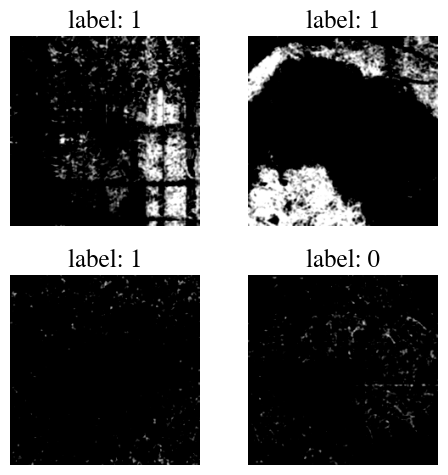

In [33]:
# show some images
fig = plt.figure(figsize=(5, 5))
for i in range(4):
	img, label = dataset[i * 50]
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img.permute(1, 2, 0).numpy())
	ax.set_axis_off()
	ax.set_title(f'label: {label}')

# save image
plt.tight_layout()
plt.savefig('plots/data.png', dpi=500)

In [34]:
# load pretrained resent models
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

# create custom resnet model
class ResNet(nn.Module):
	def __init__(self, model_name):
		super(ResNet, self).__init__()
		if model_name == 'resnet18':
			self.model = resnet18(weights="IMAGENET1K_V1")
		elif model_name == 'resnet34':
			self.model = resnet34(weights="IMAGENET1K_V1")
		elif model_name == 'resnet50':
			self.model = resnet50(weights="IMAGENET1K_V1")
		elif model_name == 'resnet101':
			self.model = resnet101(weights="IMAGENET1K_V1")
		elif model_name == 'resnet152':
			self.model = resnet152(weights="IMAGENET1K_V1")
		else:
			raise Exception('Invalid model name')

		# change the last layer
		self.model.fc = nn.Linear(self.model.fc.in_features, 1)
		self.model.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.model(x)
		return self.model.sigmoid(x)

In [35]:
# define vanilla CNN model
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
		self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

		self.fc1 = nn.Linear(128 * 14 * 14, 512)
		self.fc2 = nn.Linear(512, 1)
		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.pool(self.relu(self.conv1(x)))
		x = self.pool(self.relu(self.conv2(x)))
		x = self.pool(self.relu(self.conv3(x)))
		x = self.pool(self.relu(self.conv4(x)))

		x = x.view(-1, 128 * 14 * 14)
		x = self.relu(self.fc1(x))
		x = self.sigmoid(self.fc2(x))
		return x

In [36]:
labels = []
for _, label in dataset:
	labels.append(label)

In [37]:
# perform 5 fold cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# create 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = list(skf.split(np.zeros(len(labels)), labels))

In [38]:
# train model
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

def train_resnet(model_name, warmup_epochs=3, fine_tune_epochs=None, lr=1e-4, batch_size=32):
	fold_count = 1

	# perform 10 fold cross validation
	for train_idx, test_idx in folds:
		# reset model
		if model_name == 'cnn':
			model = CNN()
			model = model.to(device)
		else:
			model = ResNet(model_name)
			model = model.to(device)

		# define loss function and optimizer
		criterion = nn.BCELoss()
		optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

		best_loss = np.inf

		# split train to train and validation
		train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

		# create dataloaders
		train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
		val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=True)


		if fine_tune_epochs is None or fine_tune_epochs == 0:
			fine_tune_epochs = 0
		else:
			# freeze all layers except last
			for param in model.parameters():
				param.requires_grad = False
			for param in model.model.fc.parameters():
				param.requires_grad = True

		# train model
		for epoch in range(warmup_epochs + fine_tune_epochs):
			# unfreeze all layers after warmup
			if epoch == warmup_epochs:
				for param in model.parameters():
					param.requires_grad = True

			# train
			model.train()
			train_loss = 0
			train_acc = 0
			train_precision = 0
			train_recall = 0
			train_f1 = 0
			for img, label in train_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# backward pass
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

				# calculate metrics
				train_loss += loss.item()
				train_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				train_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				train_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			train_loss /= len(train_loader)
			train_acc /= len(train_loader)
			train_precision /= len(train_loader)
			train_recall /= len(train_loader)
			train_f1 /= len(train_loader)

			train_loss_list.append(train_loss)
			train_acc_list.append(train_acc)
			train_precision_list.append(train_precision)
			train_recall_list.append(train_recall)
			train_f1_list.append(train_f1)

			# evaluate model on validation set
			model.eval()

			val_loss = 0
			val_acc = 0
			val_precision = 0
			val_recall = 0
			val_f1 = 0
			for img, label in val_loader:
				img = img.to(device)
				label = label.to(device)

				# forward pass
				output = model(img)
				loss = criterion(output, label.float().unsqueeze(1))

				# calculate metrics
				val_loss += loss.item()
				val_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
				val_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)
				val_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int), zero_division=1)

			# calculate average metrics
			val_loss /= len(val_loader)
			val_acc /= len(val_loader)
			val_precision /= len(val_loader)
			val_recall /= len(val_loader)
			val_f1 /= len(val_loader)

			val_loss_list.append(val_loss)
			val_acc_list.append(val_acc)
			val_precision_list.append(val_precision)
			val_recall_list.append(val_recall)
			val_f1_list.append(val_f1)

			# print metrics
			print(f'Epoch: {epoch+1}\n\
			Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}\n\
			Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
			print()

			# save best model
			if val_loss < best_loss:
				best_loss = val_loss
				torch.save(model.state_dict(), f'{model_name}_{fold_count}.pt')

		fold_count += 1



In [74]:
# evaluate model on test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

def test_resnet(model_name, batch_size=32):
	for i in range(1, 6):
		# load model
		if model_name == 'cnn':
			model = CNN()
			model.load_state_dict(torch.load(f'{model_name}_{i}.pt'))
			model = model.to(device)
		else:
			model = ResNet(model_name)
			model.load_state_dict(torch.load(f'{model_name}_{i}.pt'))
			model = model.to(device)

		model.eval()

		test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[i-1][1]), batch_size=batch_size, shuffle=True)

		y_true = []
		y_pred = []

		test_acc = 0
		test_precision = 0
		test_recall = 0
		test_f1 = 0

		for img, label in test_loader:
			img = img.to(device)
			label = label.to(device)

			# forward pass
			output = model(img)

			# calculate metrics
			y_true.extend(label.cpu().numpy())
			y_pred.extend((output.cpu().detach().numpy() > 0.5).astype(int))

			# calculate metrics
			test_acc += accuracy_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_precision += precision_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_recall += recall_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))
			test_f1 += f1_score(label.cpu().numpy(), (output.cpu().detach().numpy() > 0.5).astype(int))

		# calculate average metrics
		test_acc /= len(test_loader)
		test_precision /= len(test_loader)
		test_recall /= len(test_loader)
		test_f1 /= len(test_loader)

		test_acc_list.append(test_acc)
		test_precision_list.append(test_precision)
		test_recall_list.append(test_recall)
		test_f1_list.append(test_f1)

		# print metrics
		print(f'Fold: {i} Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')
		print('--------------------------------------------------')


		cm = confusion_matrix(y_true, y_pred)
		sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
		# add title
		plt.title(f'Test Dataset Confusion Matrix for Fold {i}')
		plt.xlabel('Predicted')
		plt.ylabel('True')
		plt.savefig(f'plots/{model_name}/confusion_matrix_{i}.png', dpi=300)
		# clear plot
		plt.clf()

		# auc-roc curve
		fpr, tpr, _ = roc_curve(y_true, y_pred)
		# calculate AUC
		auc_score = auc(fpr, tpr)
		test_auc_list.append(auc_score)

		# plot the roc curve for the model
		plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.4f}')
		# axis labels
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		# show the legend
		plt.legend()
		# save the plot
		plt.savefig(f'plots/{model_name}/roc_curve_{i}.png', dpi=300)
		# clear plot
		plt.clf()



### Train Resnet18

In [40]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

warmup_epochs = 10
fine_tune_epochs = 10

# train resnet18
train_resnet('resnet18', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.7429, Train Acc: 0.4408, Train Precision: 0.5079, Train Recall: 0.4748, Train F1: 0.4784
			Val Loss: 0.6600, Val Acc: 0.6350, Val Precision: 0.6207, Val Recall: 1.0000, Val F1: 0.7564

Epoch: 2
			Train Loss: 0.7057, Train Acc: 0.4649, Train Precision: 0.5368, Train Recall: 0.5395, Train F1: 0.5139
			Val Loss: 0.6410, Val Acc: 0.6500, Val Precision: 0.6429, Val Recall: 1.0000, Val F1: 0.7629

Epoch: 3
			Train Loss: 0.7328, Train Acc: 0.4320, Train Precision: 0.4781, Train Recall: 0.5096, Train F1: 0.4617
			Val Loss: 0.7383, Val Acc: 0.6050, Val Precision: 0.5979, Val Recall: 1.0000, Val F1: 0.7396

Epoch: 4
			Train Loss: 0.7142, Train Acc: 0.4912, Train Precision: 0.5521, Train Recall: 0.5756, Train F1: 0.5389
			Val Loss: 0.7154, Val Acc: 0.6350, Val Precision: 0.6410, Val Recall: 0.9667, Val F1: 0.7413

Epoch: 5
			Train Loss: 0.7305, Train Acc: 0.4342, Train Precision: 0.5123, Train Recall: 0.5235, Train F1: 0.5040
			Val Loss: 0.7184, Val Acc: 0.4800,

In [41]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

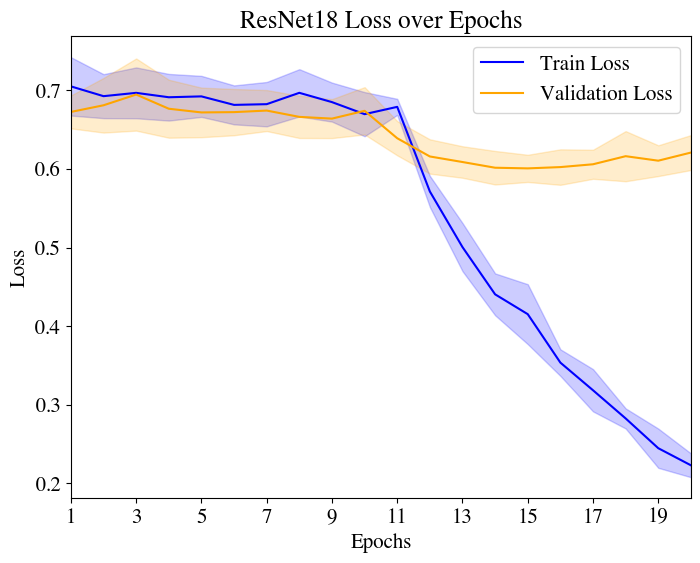

In [42]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# limit x tick to be integers
plt.xticks(np.arange(1, num_epochs+1, 2.0))
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet18 Loss over Epochs')
plt.legend()
plt.savefig('plots/resnet18/loss.png', dpi=300)


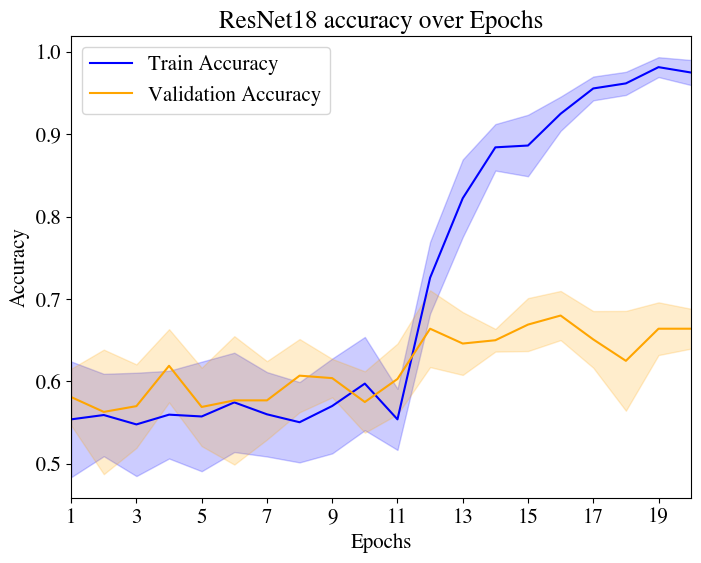

In [43]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# limit x tick to be integers
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet18 accuracy over Epochs')
plt.legend()
plt.savefig('plots/resnet18/accuracy.png', dpi=300)


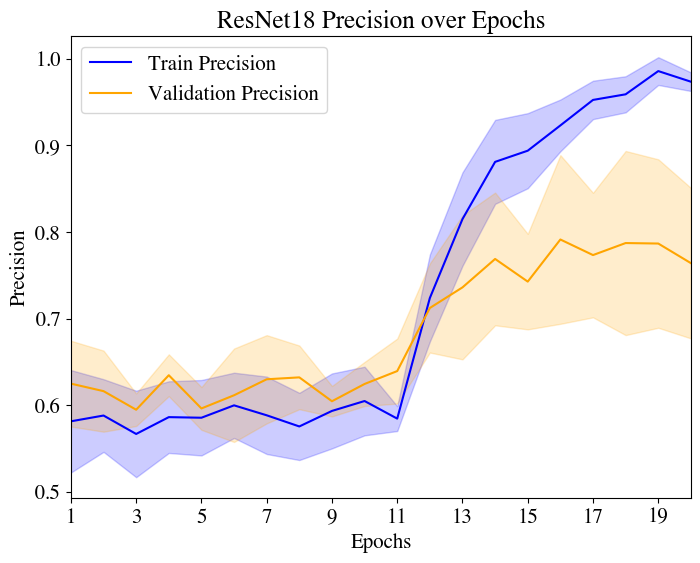

In [44]:
# plot average precision across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_precision_list, axis=0)
std_values = np.std(train_precision_list, axis=0)

plt.plot(epochs, mean_values, label='Train Precision', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_precision_list, axis=0)
std_values = np.std(val_precision_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Precision', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# limit x tick to be integers
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('ResNet18 Precision over Epochs')
plt.legend()
plt.savefig('plots/resnet18/precision.png', dpi=300)


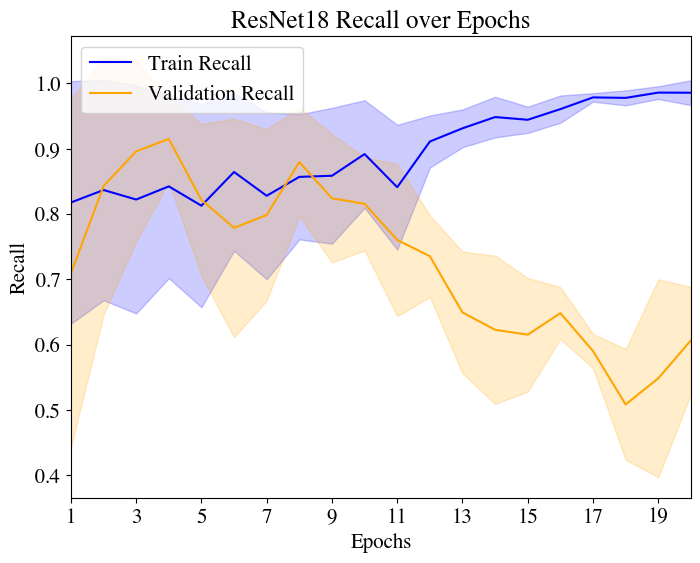

In [45]:
# plot average recall across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_recall_list, axis=0)
std_values = np.std(train_recall_list, axis=0)

plt.plot(epochs, mean_values, label='Train Recall', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_recall_list, axis=0)
std_values = np.std(val_recall_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Recall', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# limit x tick to be integers
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('ResNet18 Recall over Epochs')
plt.legend()
plt.savefig('plots/resnet18/recall.png', dpi=300)


In [47]:
# save metrics
np.save('plots/resnet18/train_loss.npy', train_loss_list)
np.save('plots/resnet18/train_acc.npy', train_acc_list)
np.save('plots/resnet18/train_precision.npy', train_precision_list)
np.save('plots/resnet18/train_recall.npy', train_recall_list)
np.save('plots/resnet18/train_f1.npy', train_f1_list)

np.save('plots/resnet18/val_loss.npy', val_loss_list)
np.save('plots/resnet18/val_acc.npy', val_acc_list)
np.save('plots/resnet18/val_precision.npy', val_precision_list)
np.save('plots/resnet18/val_recall.npy', val_recall_list)
np.save('plots/resnet18/val_f1.npy', val_f1_list)

In [48]:
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test resnet18
test_resnet('resnet18')

Fold: 1 Test Acc: 0.6897, Test Precision: 0.7146, Test Recall: 0.7735, Test F1: 0.7429
--------------------------------------------------
Fold: 2 Test Acc: 0.6250, Test Precision: 0.6500, Test Recall: 0.7571, Test F1: 0.6941
--------------------------------------------------
Fold: 3 Test Acc: 0.6853, Test Precision: 0.7418, Test Recall: 0.7222, Test F1: 0.7317
--------------------------------------------------
Fold: 4 Test Acc: 0.7165, Test Precision: 0.8750, Test Recall: 0.6333, Test F1: 0.7333
--------------------------------------------------
Fold: 5 Test Acc: 0.5312, Test Precision: 0.5658, Test Recall: 0.4586, Test F1: 0.4976
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [49]:
# save metrics
np.save('plots/resnet18/test_acc.npy', test_acc_list)
np.save('plots/resnet18/test_precision.npy', test_precision_list)
np.save('plots/resnet18/test_recall.npy', test_recall_list)
np.save('plots/resnet18/test_f1.npy', test_f1_list)
np.save('plots/resnet18/test_auc.npy', test_auc_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


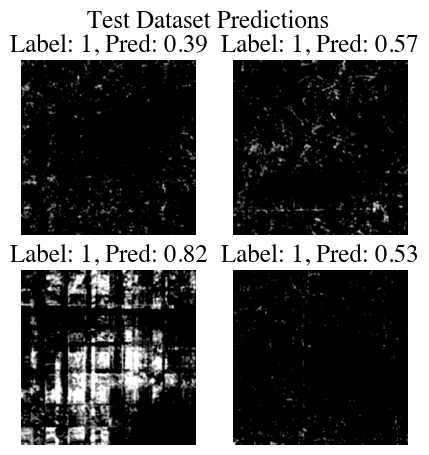

In [50]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = ResNet('resnet18')
model.load_state_dict(torch.load(f'resnet18_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('Test Dataset Predictions')
# save image
plt.savefig('plots/resnet18/predictions.png', dpi=300)

In [51]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.65\pm0.07$ &$0.71\pm0.10$ &$0.67\pm0.12$ &$0.68\pm0.09$ &$0.65\pm0.06$


In [52]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list), np.std(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list), np.std(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list), np.std(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list), np.std(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list), np.std(test_auc_list))


Average Test Accuracy:  0.6495535714285714 0.06629126073623884
Average Test Precision:  0.7094532007380305 0.10262058628522057
Average Test Recall:  0.6689748882008943 0.11580053542022371
Average Test F1:  0.6799323620995448 0.0926707818780576
Average Test AUC:  0.6466629179787075 0.06179221906660159


### Train ResNet50

In [53]:
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

# train resnet18
warmup_epochs = 10
fine_tune_epochs = 8

# train resnet18
train_resnet('resnet50', warmup_epochs=warmup_epochs, fine_tune_epochs=fine_tune_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.6979, Train Acc: 0.5044, Train Precision: 0.5542, Train Recall: 0.8262, Train F1: 0.6395
			Val Loss: 0.6874, Val Acc: 0.5950, Val Precision: 0.6443, Val Recall: 0.7667, Val F1: 0.6752

Epoch: 2
			Train Loss: 0.6887, Train Acc: 0.5855, Train Precision: 0.5912, Train Recall: 0.9451, Train F1: 0.7153
			Val Loss: 0.6787, Val Acc: 0.5550, Val Precision: 0.5800, Val Recall: 0.9381, Val F1: 0.6929

Epoch: 3
			Train Loss: 0.6880, Train Acc: 0.5482, Train Precision: 0.5736, Train Recall: 0.9464, Train F1: 0.6896
			Val Loss: 0.6928, Val Acc: 0.4600, Val Precision: 0.5200, Val Recall: 0.4867, Val F1: 0.4823

Epoch: 4
			Train Loss: 0.6845, Train Acc: 0.5439, Train Precision: 0.5627, Train Recall: 0.9241, Train F1: 0.6803
			Val Loss: 0.6809, Val Acc: 0.5300, Val Precision: 0.5417, Val Recall: 0.8200, Val F1: 0.6387

Epoch: 5
			Train Loss: 0.6833, Train Acc: 0.5592, Train Precision: 0.5724, Train Recall: 0.9246, Train F1: 0.6889
			Val Loss: 0.6751, Val Acc: 0.5850,

In [54]:
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)

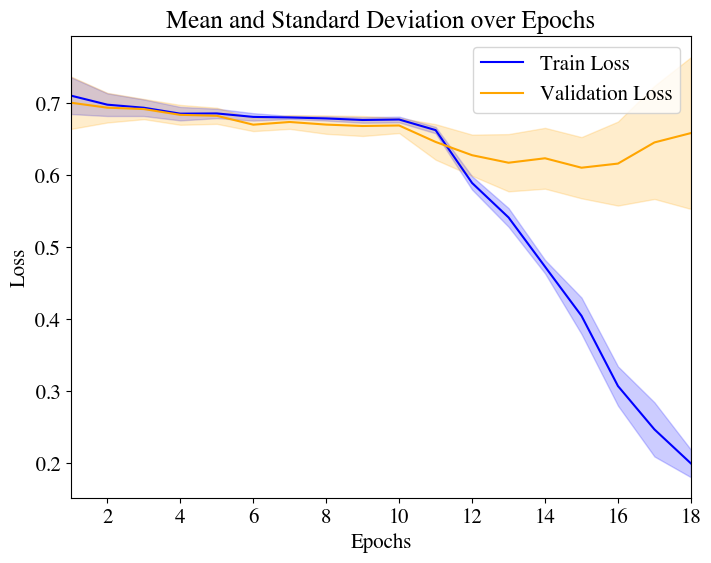

In [55]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
# plt.ylim(0, 1.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mean and Standard Deviation over Epochs')
plt.legend()
plt.savefig('plots/resnet50/loss.png', dpi=300)


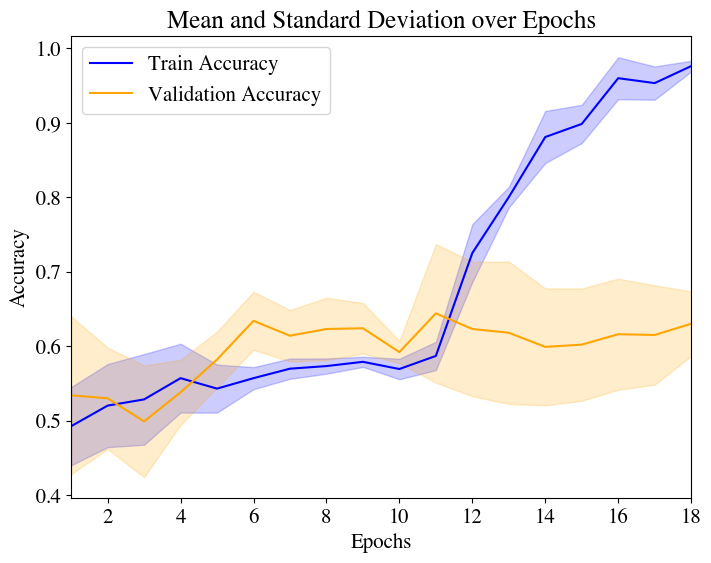

In [56]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Mean and Standard Deviation over Epochs')
plt.legend()
plt.savefig('plots/resnet50/accuracy.png', dpi=300)

In [57]:
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []

# test resnet18
test_resnet('resnet50')

Fold: 1 Test Acc: 0.6473, Test Precision: 0.6768, Test Recall: 0.7045, Test F1: 0.6898
--------------------------------------------------
Fold: 2 Test Acc: 0.5871, Test Precision: 0.6458, Test Recall: 0.6382, Test F1: 0.6387
--------------------------------------------------
Fold: 3 Test Acc: 0.6406, Test Precision: 0.7333, Test Recall: 0.6944, Test F1: 0.7097
--------------------------------------------------
Fold: 4 Test Acc: 0.7165, Test Precision: 0.6905, Test Recall: 0.7864, Test F1: 0.7287
--------------------------------------------------
Fold: 5 Test Acc: 0.4487, Test Precision: 0.5000, Test Recall: 0.4248, Test F1: 0.4567
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


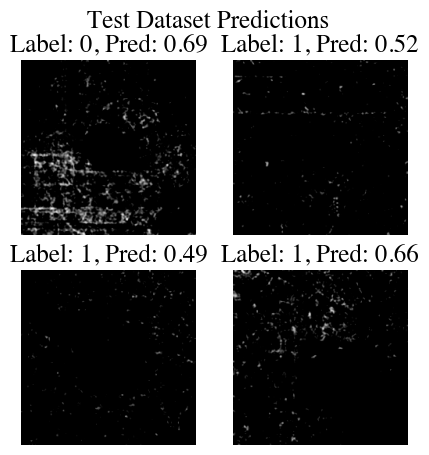

In [58]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = ResNet('resnet50')
model.load_state_dict(torch.load(f'resnet50_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('Test Dataset Predictions')
# save image
plt.savefig('plots/resnet50/predictions.png', dpi=300)

In [59]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list))


Average Test Accuracy:  0.6080357142857143
Average Test Precision:  0.6492821067821067
Average Test Recall:  0.6496646920331131
Average Test F1:  0.6447232058507167
Average Test AUC:  0.5926975558554506


In [60]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.61\pm0.09$ &$0.65\pm0.08$ &$0.65\pm0.12$ &$0.64\pm0.10$ &$0.59\pm0.09$


### Train Vanilla Model

In [61]:
from torchsummary import summary

# initialize model
model = CNN()
model = model.to(device)

# print model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Linear-13                  [-1, 512]      12,845,568
             ReLU-14                  [

In [62]:
# train model
train_loss_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []

warmup_epochs = 25
fine_tune_epochs = 0

# train cnn
train_resnet(model_name='cnn', warmup_epochs=warmup_epochs, lr=1e-5, batch_size=8)

Epoch: 1
			Train Loss: 0.6891, Train Acc: 0.5724, Train Precision: 0.6842, Train Recall: 0.8026, Train F1: 0.6005
			Val Loss: 0.6866, Val Acc: 0.5800, Val Precision: 0.5800, Val Recall: 1.0000, Val F1: 0.7267

Epoch: 2
			Train Loss: 0.6851, Train Acc: 0.5702, Train Precision: 0.5702, Train Recall: 1.0000, Train F1: 0.7075
			Val Loss: 0.6840, Val Acc: 0.5650, Val Precision: 0.5650, Val Recall: 1.0000, Val F1: 0.6805

Epoch: 3
			Train Loss: 0.6777, Train Acc: 0.5921, Train Precision: 0.5921, Train Recall: 1.0000, Train F1: 0.7285
			Val Loss: 0.6834, Val Acc: 0.5650, Val Precision: 0.5650, Val Recall: 1.0000, Val F1: 0.6824

Epoch: 4
			Train Loss: 0.6815, Train Acc: 0.5702, Train Precision: 0.5702, Train Recall: 1.0000, Train F1: 0.7136
			Val Loss: 0.6780, Val Acc: 0.5800, Val Precision: 0.5800, Val Recall: 1.0000, Val F1: 0.7267

Epoch: 5
			Train Loss: 0.6740, Train Acc: 0.5921, Train Precision: 0.5921, Train Recall: 1.0000, Train F1: 0.7253
			Val Loss: 0.6781, Val Acc: 0.5800,

In [63]:
# reshape lists
num_epochs = warmup_epochs + fine_tune_epochs

train_loss_list = np.array(train_loss_list).reshape(5, num_epochs)
train_acc_list = np.array(train_acc_list).reshape(5, num_epochs)
train_precision_list = np.array(train_precision_list).reshape(5, num_epochs)
train_recall_list = np.array(train_recall_list).reshape(5, num_epochs)
train_f1_list = np.array(train_f1_list).reshape(5, num_epochs)

val_loss_list = np.array(val_loss_list).reshape(5, num_epochs)
val_acc_list = np.array(val_acc_list).reshape(5, num_epochs)
val_precision_list = np.array(val_precision_list).reshape(5, num_epochs)
val_recall_list = np.array(val_recall_list).reshape(5, num_epochs)
val_f1_list = np.array(val_f1_list).reshape(5, num_epochs)


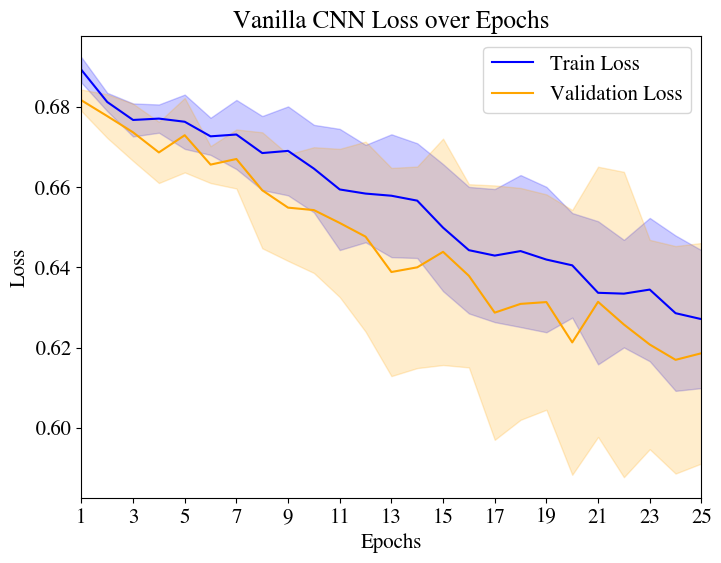

In [64]:
# plot average loss across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_loss_list, axis=0)
std_values = np.std(train_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_loss_list, axis=0)
std_values = np.std(val_loss_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Vanilla CNN Loss over Epochs')
plt.legend()
plt.savefig('plots/cnn/loss.png', dpi=300)

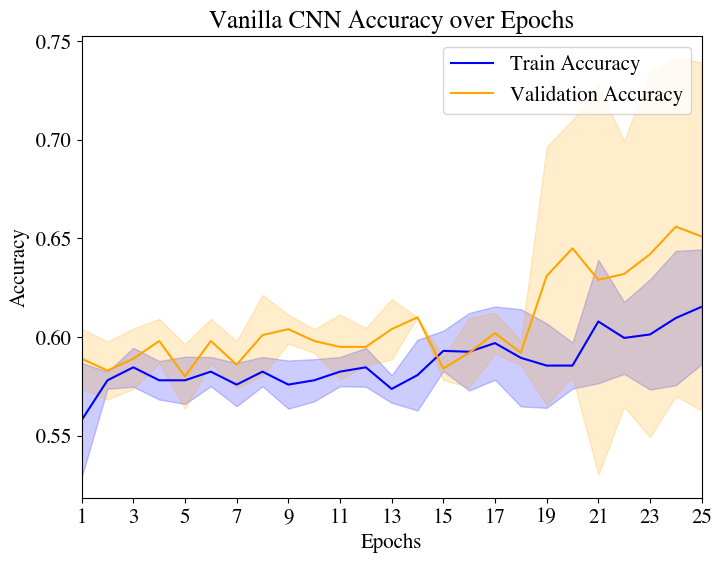

In [65]:
# plot average accuracy across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_acc_list, axis=0)
std_values = np.std(train_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_acc_list, axis=0)
std_values = np.std(val_acc_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Vanilla CNN Accuracy over Epochs')
plt.legend()
plt.savefig('plots/cnn/accuracy.png', dpi=300)

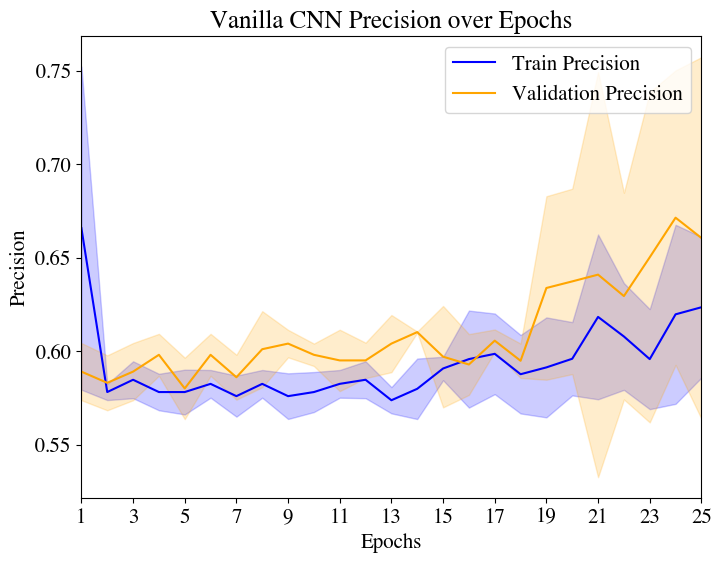

In [66]:
# plot average precision across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_precision_list, axis=0)
std_values = np.std(train_precision_list, axis=0)

plt.plot(epochs, mean_values, label='Train Precision', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_precision_list, axis=0)
std_values = np.std(val_precision_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Precision', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Vanilla CNN Precision over Epochs')
plt.legend()
plt.savefig('plots/cnn/precision.png', dpi=300)

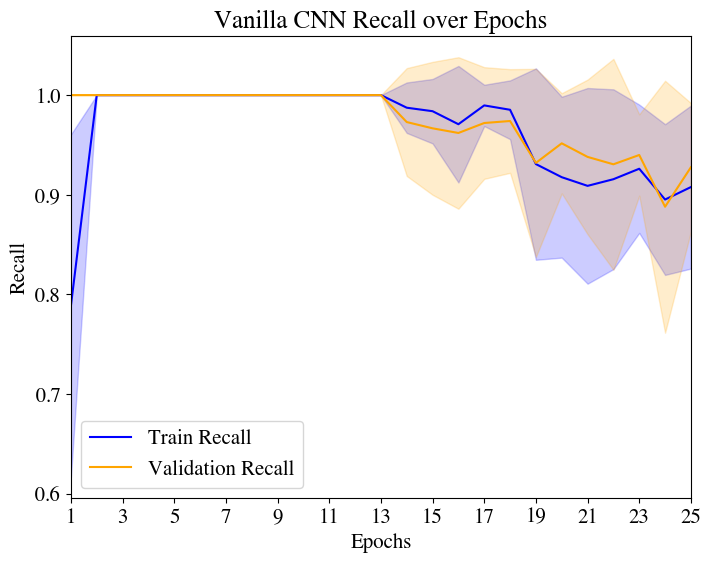

In [67]:
# plot average recall across 5 folds
plt.figure(figsize=(8, 6))

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(train_recall_list, axis=0)
std_values = np.std(train_recall_list, axis=0)

plt.plot(epochs, mean_values, label='Train Recall', color='blue')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='blue')

epochs = np.arange(1, num_epochs+1)  # Epochs
mean_values = np.mean(val_recall_list, axis=0)
std_values = np.std(val_recall_list, axis=0)

plt.plot(epochs, mean_values, label='Validation Recall', color='orange')
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2, color='orange')

# Set plot labels and title
plt.xlim(1, num_epochs)
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Vanilla CNN Recall over Epochs')
plt.legend()
plt.savefig('plots/cnn/recall.png', dpi=300)

In [68]:
# save metrics
np.save('plots/cnn/train_loss.npy', train_loss_list)
np.save('plots/cnn/train_acc.npy', train_acc_list)
np.save('plots/cnn/train_precision.npy', train_precision_list)
np.save('plots/cnn/train_recall.npy', train_recall_list)
np.save('plots/cnn/train_f1.npy', train_f1_list)

np.save('plots/cnn/val_loss.npy', val_loss_list)
np.save('plots/cnn/val_acc.npy', val_acc_list)
np.save('plots/cnn/val_precision.npy', val_precision_list)
np.save('plots/cnn/val_recall.npy', val_recall_list)
np.save('plots/cnn/val_f1.npy', val_f1_list)

In [75]:
# test vanilla cnn
test_loss_list = []
test_acc_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_acc_list = []

test_resnet('cnn')

Fold: 1 Test Acc: 0.5982, Test Precision: 0.5859, Test Recall: 0.9750, Test F1: 0.7300
--------------------------------------------------
Fold: 2 Test Acc: 0.7254, Test Precision: 0.7292, Test Recall: 0.8917, Test F1: 0.7917
--------------------------------------------------
Fold: 3 Test Acc: 0.5625, Test Precision: 0.5625, Test Recall: 1.0000, Test F1: 0.7179
--------------------------------------------------
Fold: 4 Test Acc: 0.5938, Test Precision: 0.5968, Test Recall: 0.9375, Test F1: 0.7292
--------------------------------------------------
Fold: 5 Test Acc: 0.4844, Test Precision: 0.5417, Test Recall: 0.7418, Test F1: 0.6260
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [76]:
# save metrics
np.save('plots/cnn/test_acc.npy', test_acc_list)
np.save('plots/cnn/test_precision.npy', test_precision_list)
np.save('plots/cnn/test_recall.npy', test_recall_list)
np.save('plots/cnn/test_f1.npy', test_f1_list)
np.save('plots/cnn/test_auc.npy', test_auc_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


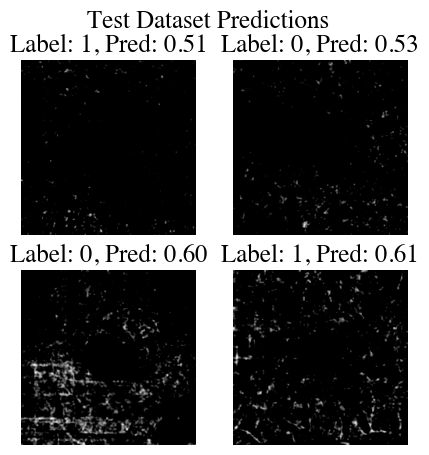

In [77]:
# show some images and predictions
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=4, shuffle=True)
model = CNN()
model.load_state_dict(torch.load(f'cnn_1.pt'))

dataiter = iter(test_loader)
img, label = next(dataiter)
img = img.to(device)
label = label.to(device)
output = model(img)

fig = plt.figure(figsize=(5, 5))
for i in range(4):
	ax = fig.add_subplot(2, 2, i+1)
	ax.imshow(img[i].permute(1, 2, 0).cpu().numpy())
	ax.set_axis_off()
	ax.set_title(f'Label: {label[i].cpu().numpy()}, Pred: {(output[i].cpu().detach().numpy())[0]:.2f}')

# add title
plt.suptitle('Test Dataset Predictions')
# save image
plt.savefig('plots/cnn/predictions.png', dpi=300)


In [78]:
# calculate average metrics for all folds
print('Average Test Accuracy: ', np.mean(test_acc_list))
print('Average Test Precision: ', np.mean(test_precision_list))
print('Average Test Recall: ', np.mean(test_recall_list))
print('Average Test F1: ', np.mean(test_f1_list))
print('Average Test AUC: ', np.mean(test_auc_list))

Average Test Accuracy:  0.5928571428571429
Average Test Precision:  0.6032095490716181
Average Test Recall:  0.9091993464052287
Average Test F1:  0.7189596622889306
Average Test AUC:  0.5327162992952467


In [79]:
# calculate average metrics for all folds print in latex format
print('&${0:.2f}\pm{1:.2f}$'.format(np.mean(test_acc_list), np.std(test_acc_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_precision_list), np.std(test_precision_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_recall_list), np.std(test_recall_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_f1_list), np.std(test_f1_list)) + ' &${0:.2f}\pm{1:.2f}$'.format(np.mean(test_auc_list), np.std(test_auc_list)))

&$0.59\pm0.08$ &$0.60\pm0.07$ &$0.91\pm0.09$ &$0.72\pm0.05$ &$0.53\pm0.06$


### Activation Visualization 

In [130]:
# Load a pre-trained model
model = CNN()
model.load_state_dict(torch.load('cnn_1.pt'))

<All keys matched successfully>

In [142]:
test_loader = DataLoader(torch.utils.data.Subset(dataset, folds[0][1]), batch_size=1, shuffle=True)
dataiter = iter(test_loader)
img, label = next(dataiter)

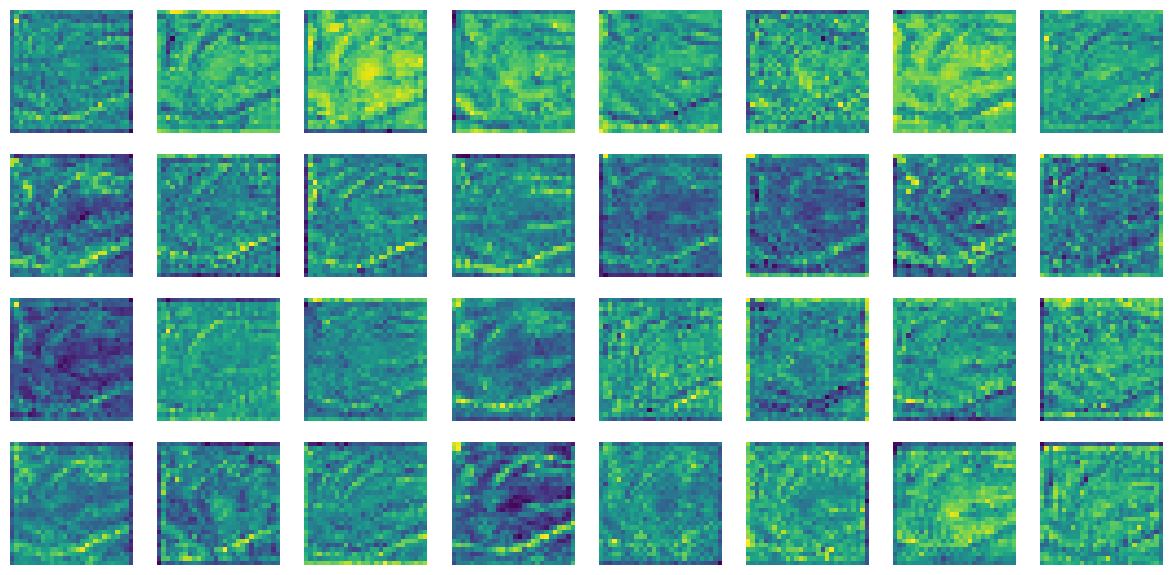

In [146]:
# Function to get activations from a specific layer
def get_activations(image, model, layer_num):
    activations = None
    model_children = list(model.children())

    activations = torch.zeros(1, model_children[layer_num].out_channels, 0, 0)
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output.detach()
    model_children[layer_num].register_forward_hook(hook_fn)
    model(image)
    return activations

# Choose a layer number to visualize its features (e.g., layer 4 in ResNet)
layer_number = 3
activations = get_activations(img, model, layer_number)[0]

# Visualize some of the activation maps
num_features = activations.size(0)
plt.figure(figsize=(12, 6))
for i in range(min(32, num_features)):
    plt.subplot(4, 8, i+1)
    plt.imshow(activations[i].cpu(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.savefig(f'plots/cnn/activations_layer-{layer_number}.png', dpi=300)

In [162]:
img, label = next(dataiter)
label

tensor([1])

In [163]:
img = img.to(device)
label = label.to(device)
output = model(img)
output

tensor([[0.5049]], grad_fn=<SigmoidBackward0>)

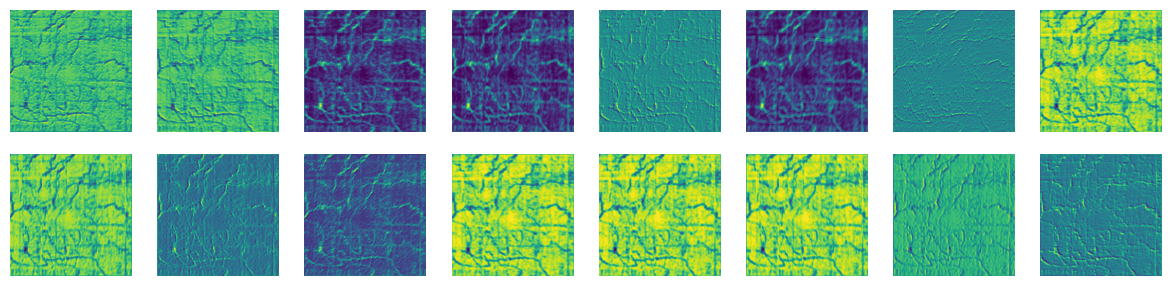

In [167]:
# Choose a layer number to visualize its features (e.g., layer 4 in ResNet)
layer_number = 0
activations = get_activations(img, model, layer_number)[0]

# Visualize some of the activation maps
num_features = activations.size(0)
plt.figure(figsize=(12, 6))
for i in range(min(32, num_features)):
    plt.subplot(4, 8, i+1)
    plt.imshow(activations[i].cpu(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.savefig(f'plots/cnn/activations_layer-{layer_number}_label-1.png', dpi=300)